Aim : To predict interest rate of credit based on borrower and loan attributes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from patsy import dmatrices
import scipy.stats as stats
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression, RFE, SelectKBest, f_oneway
from sklearn.linear_model import LinearRegression

In [2]:
loan_data=pd.read_csv('../input/LoansData.csv')

In [3]:
loan_data.tail(2)

,LoanID,Amount.Requested,Amount.Funded.By.Investors,Interest.Rate,Loan.Length,Loan.Purpose,Debt.To.Income.Ratio,State,Home.Ownership,Monthly.Income,FICO.Range,Open.CREDIT.Lines,Revolving.CREDIT.Balance,Inquiries.in.the.Last.6.Months,Employment.Length
2498,2499,6000.0,6000.00,12.42%,36 months,major_purchase,16.66%,NJ,RENT,3500.0,675-679,8.0,7753.0,0.0,5 years
2499,2500,9000.0,5242.75,13.79%,36 months,debt_consolidation,6.76%,NY,RENT,3875.0,670-674,7.0,7589.0,0.0,10+ years


## Data Wrangling

In [4]:
loan_data.columns

Index(['LoanID', 'Amount.Requested', 'Amount.Funded.By.Investors',
       'Interest.Rate', 'Loan.Length', 'Loan.Purpose', 'Debt.To.Income.Ratio',
       'State', 'Home.Ownership', 'Monthly.Income', 'FICO.Range',
       'Open.CREDIT.Lines', 'Revolving.CREDIT.Balance',
       'Inquiries.in.the.Last.6.Months', 'Employment.Length'],
      dtype='object')

In [5]:
#replacing '.' with '_' in column names
loan_data.columns=loan_data.columns.str.replace('.','_')

In [6]:
loan_data.columns

Index(['LoanID', 'Amount_Requested', 'Amount_Funded_By_Investors',
       'Interest_Rate', 'Loan_Length', 'Loan_Purpose', 'Debt_To_Income_Ratio',
       'State', 'Home_Ownership', 'Monthly_Income', 'FICO_Range',
       'Open_CREDIT_Lines', 'Revolving_CREDIT_Balance',
       'Inquiries_in_the_Last_6_Months', 'Employment_Length'],
      dtype='object')

In [7]:
loan_data.head(2)

,LoanID,Amount_Requested,Amount_Funded_By_Investors,Interest_Rate,Loan_Length,Loan_Purpose,Debt_To_Income_Ratio,State,Home_Ownership,Monthly_Income,FICO_Range,Open_CREDIT_Lines,Revolving_CREDIT_Balance,Inquiries_in_the_Last_6_Months,Employment_Length
0,1,20000.0,20000.0,8.90%,36 months,debt_consolidation,14.90%,SC,MORTGAGE,6541.67,735-739,14.0,14272.0,2.0,< 1 year
1,2,19200.0,19200.0,12.12%,36 months,debt_consolidation,28.36%,TX,MORTGAGE,4583.33,715-719,12.0,11140.0,1.0,2 years


In [8]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 15 columns):
LoanID                            2500 non-null int64
Amount_Requested                  2499 non-null float64
Amount_Funded_By_Investors        2499 non-null float64
Interest_Rate                     2498 non-null object
Loan_Length                       2500 non-null object
Loan_Purpose                      2500 non-null object
Debt_To_Income_Ratio              2499 non-null object
State                             2500 non-null object
Home_Ownership                    2499 non-null object
Monthly_Income                    2499 non-null float64
FICO_Range                        2498 non-null object
Open_CREDIT_Lines                 2497 non-null float64
Revolving_CREDIT_Balance          2497 non-null float64
Inquiries_in_the_Last_6_Months    2497 non-null float64
Employment_Length                 2423 non-null object
dtypes: float64(6), int64(1), object(8)
memory usage: 293.1+ KB

In [9]:
# removing "%" symbol from interest rate column and converting it to float type
loan_data['Interest_Rate'] = loan_data['Interest_Rate'].apply(lambda a : str(a).strip('%')).astype('float64')

In [10]:
# stripping " months" from loan length column and converting it to int type
loan_data['Loan_Length'] = loan_data['Loan_Length'].apply(lambda b : str(b).strip(' months')).astype('int64')

In [11]:
# Stripping "%" symbol from Debt to Income Ratio column and converting it to float type
loan_data["Debt_To_Income_Ratio"] = loan_data["Debt_To_Income_Ratio"].apply(lambda c :str(c).strip('%')).astype('float64')

In [12]:
# FICO range column gives us range, converting it to single value by taking avg of range
a=loan_data['FICO_Range'].str.split('-',expand=True).astype('float64')

In [13]:
a['AVG']=(a[0]+a[1])/2
a.head()

,0,1,AVG
0,735.0,739.0,737.0
1,715.0,719.0,717.0
2,690.0,694.0,692.0
3,695.0,699.0,697.0
4,695.0,699.0,697.0


In [14]:
#adding FICO avergae to original dataframe and dropping FICO Range
loan_data['Fico_Avg']=a['AVG']
loan_data.drop(columns=['FICO_Range'],inplace=True)

In [15]:
# correcting emplyment length column
loan_data['Employment_Length']=loan_data['Employment_Length'].str.replace('<','')
loan_data['Employment_Length']=loan_data['Employment_Length'].str.replace('+','')
loan_data['Employment_Length']=loan_data['Employment_Length'].str.replace(' years','')
loan_data['Employment_Length']=loan_data['Employment_Length'].str.replace(' year','')
loan_data['Employment_Length']=loan_data['Employment_Length'].str.lstrip()
loan_data['Employment_Length']=loan_data['Employment_Length'].str.rstrip()

In [16]:
loan_data['Employment_Length'].tail()

2495     8
2496    10
2497    10
2498     5
2499    10
Name: Employment_Length, dtype: object

In [17]:
# for stats of continuous variables
def con_stats(x):
    return pd.Series({'Count':x.count(),'NaNs':x.isnull().sum(),'%NaNs':(x.isnull().sum())/(x.count()),'Sum':x.sum(),'Mean':x.mean(),
                      'Coef. Var':x.std()/x.mean(),'Min':x.min(),'P1':x.quantile(.01),'P10':x.quantile(.1),'P25':x.quantile(.25),'P50':x.quantile(.5),
                      'P75':x.quantile(.75),'P90':x.quantile(.9),'P99':x.quantile(.99),'Max':x.max()})

In [18]:
# for stats of categorical var
def cat_stats(y):
    return pd.Series({'Count':y.count(),'Uniques':y.value_counts().count(),'NaNs':y.isnull().sum(),'%NaNs':(y.isnull().sum())/y.count(),'Mode':y.mode()[0],'Freq. Mode':y.value_counts()[0]})

In [19]:
# missing value imputation
def misses(x):
    if (x.dtype=='int64')|(x.dtype=='float64'):
        x.fillna(value=x.median(),inplace=True)
    else :
        x.fillna(x.mode()[0],inplace=True)
    return x

In [20]:
# outlier treatment
def out(y):
    y.clip(lower=y.quantile(0.01),upper=y.quantile(0.99),inplace=True)
    return y

In [21]:
loan_data.apply(misses)

,LoanID,Amount_Requested,Amount_Funded_By_Investors,Interest_Rate,Loan_Length,Loan_Purpose,Debt_To_Income_Ratio,State,Home_Ownership,Monthly_Income,Open_CREDIT_Lines,Revolving_CREDIT_Balance,Inquiries_in_the_Last_6_Months,Employment_Length,Fico_Avg
0,1,20000.0,20000.00,8.90,36,debt_consolidation,14.90,SC,MORTGAGE,6541.67,14.0,14272.0,2.0,1,737.0
1,2,19200.0,19200.00,12.12,36,debt_consolidation,28.36,TX,MORTGAGE,4583.33,12.0,11140.0,1.0,2,717.0
2,3,35000.0,35000.00,21.98,60,debt_consolidation,23.81,CA,MORTGAGE,11500.00,14.0,21977.0,1.0,2,692.0
3,4,10000.0,9975.00,9.99,36,debt_consolidation,14.30,KS,MORTGAGE,3833.33,10.0,9346.0,0.0,5,697.0
4,5,12000.0,12000.00,11.71,36,credit_card,18.78,NJ,RENT,3195.00,11.0,14469.0,0.0,9,697.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,2496,30000.0,29950.00,16.77,60,debt_consolidation,19.23,NY,MORTGAGE,9250.00,15.0,45880.0,1.0,8,707.0
2496,2497,16000.0,16000.00,14.09,60,home_improvement,21.54,MD,OWN,8903.25,18.0,18898.0,1.0,10,742.0
2497,2498,10000.0,10000.00,13.99,36,debt_consolidation,4.89,PA,MORTGAGE,2166.67,4.0,4544.0,0.0,10,682.0
2498,2499,6000.0,6000.00,12.42,36,major_purchase,16.66,NJ,RENT,3500.00,8.0,7753.0,0.0,5,677.0


In [22]:
#changing employment type and dropping unwanted columns
loan_data['Employment_Length']=loan_data['Employment_Length'].astype('int64')
loan_data.drop(columns=['LoanID','Amount_Funded_By_Investors'],inplace=True)

In [23]:
# Separating Numerical and Categorical features
num=[]
cat=[]
for i in dict(loan_data.dtypes).items():
        if (i[1]=='int64')|(i[1]=='float64'):
            num.append(i[0])
        else:
            cat.append(i[0])

In [24]:
loan_cat=loan_data[cat]
loan_num=loan_data[num]

In [25]:
loan_cat.head(2)

,Loan_Purpose,State,Home_Ownership
0,debt_consolidation,SC,MORTGAGE
1,debt_consolidation,TX,MORTGAGE


In [26]:
loan_num.head(2)

,Amount_Requested,Interest_Rate,Loan_Length,Debt_To_Income_Ratio,Monthly_Income,Open_CREDIT_Lines,Revolving_CREDIT_Balance,Inquiries_in_the_Last_6_Months,Employment_Length,Fico_Avg
0,20000.0,8.90,36,14.90,6541.67,14.0,14272.0,2.0,1,737.0
1,19200.0,12.12,36,28.36,4583.33,12.0,11140.0,1.0,2,717.0


In [27]:
loan_num.apply(con_stats).T

,Count,NaNs,%NaNs,Sum,Mean,Coef. Var,Min,P1,P10,P25,P50,P75,P90,P99,Max
Amount_Requested,2500.0,0.0,0.0,31011250.00,12404.500000,0.628927,1000.00,1500.0000,4000.000,6000.00,10000.00,17000.0000,24000.000,35000.0000,35000.00
Interest_Rate,2500.0,0.0,0.0,32663.56,13.065424,0.319586,5.42,5.9880,7.620,10.16,13.11,15.8000,18.640,22.9533,24.89
Loan_Length,2500.0,0.0,0.0,103152.00,41.260800,0.240686,36.00,36.0000,36.000,36.00,36.00,36.0000,60.000,60.0000,60.00
Debt_To_Income_Ratio,2500.0,0.0,0.0,38450.99,15.380396,0.487865,0.00,0.7190,5.309,9.75,15.32,20.6725,25.012,33.2300,34.91
Monthly_Income,2500.0,0.0,0.0,14221639.37,5688.655748,0.696535,588.50,1416.5366,2600.000,3500.00,5000.00,6800.0000,9292.830,18750.0000,102750.00
Open_CREDIT_Lines,2500.0,0.0,0.0,25179.00,10.071600,0.447284,2.00,3.0000,5.000,7.00,9.00,13.0000,16.000,23.0000,38.00
Revolving_CREDIT_Balance,2500.0,0.0,0.0,38045136.00,15218.054400,1.200590,0.00,0.0000,2299.700,5589.25,10948.00,18843.7500,29976.500,92407.6600,270800.00
Inquiries_in_the_Last_6_Months,2500.0,0.0,0.0,2264.00,0.905600,1.359111,0.00,0.0000,0.000,0.00,0.00,1.0000,3.000,5.0000,9.00
Employment_Length,2500.0,0.0,0.0,14077.00,5.630800,0.617481,1.00,1.0000,1.000,2.00,5.00,10.0000,10.000,10.0000,10.00
Fico_Avg,2500.0,0.0,0.0,1769750.00,707.900000,0.049482,642.00,662.0000,667.000,682.00,702.00,727.0000,757.000,807.0000,832.00


In [28]:
loan_cat.apply(cat_stats).T

,Count,Uniques,NaNs,%NaNs,Mode,Freq. Mode
Loan_Purpose,2500,14,0,0,debt_consolidation,1307
State,2500,46,0,0,CA,433
Home_Ownership,2500,5,0,0,MORTGAGE,1148


In [29]:
loan_num.apply(out)

,Amount_Requested,Interest_Rate,Loan_Length,Debt_To_Income_Ratio,Monthly_Income,Open_CREDIT_Lines,Revolving_CREDIT_Balance,Inquiries_in_the_Last_6_Months,Employment_Length,Fico_Avg
0,20000.0,8.90,36,14.90,6541.67,14.0,14272.0,2.0,1,737.0
1,19200.0,12.12,36,28.36,4583.33,12.0,11140.0,1.0,2,717.0
2,35000.0,21.98,60,23.81,11500.00,14.0,21977.0,1.0,2,692.0
3,10000.0,9.99,36,14.30,3833.33,10.0,9346.0,0.0,5,697.0
4,12000.0,11.71,36,18.78,3195.00,11.0,14469.0,0.0,9,697.0
...,...,...,...,...,...,...,...,...,...,...
2495,30000.0,16.77,60,19.23,9250.00,15.0,45880.0,1.0,8,707.0
2496,16000.0,14.09,60,21.54,8903.25,18.0,18898.0,1.0,10,742.0
2497,10000.0,13.99,36,4.89,2166.67,4.0,4544.0,0.0,10,682.0
2498,6000.0,12.42,36,16.66,3500.00,8.0,7753.0,0.0,5,677.0


In [30]:
loan_num.apply(con_stats).T

,Count,NaNs,%NaNs,Sum,Mean,Coef. Var,Min,P1,P10,P25,P50,P75,P90,P99,Max
Amount_Requested,2500.0,0.0,0.0,3.102028e+07,12408.110000,0.628328,1500.0000,1500.000000,4000.000,6000.00,10000.00,17000.0000,24000.000,35000.000000,35000.0000
Interest_Rate,2500.0,0.0,0.0,3.265089e+04,13.060357,0.317552,5.9880,5.989980,7.620,10.16,13.11,15.8000,18.640,22.950033,22.9533
Loan_Length,2500.0,0.0,0.0,1.031520e+05,41.260800,0.240686,36.0000,36.000000,36.000,36.00,36.00,36.0000,60.000,60.000000,60.0000
Debt_To_Income_Ratio,2500.0,0.0,0.0,3.844629e+04,15.378514,0.486326,0.7190,0.719990,5.309,9.75,15.32,20.6725,25.012,33.230000,33.2300
Monthly_Income,2500.0,0.0,0.0,1.402077e+07,5608.306794,0.549858,1416.5366,1416.668666,2600.000,3500.00,5000.00,6800.0000,9292.830,18750.000000,18750.0000
Open_CREDIT_Lines,2500.0,0.0,0.0,2.513200e+04,10.052800,0.435441,3.0000,3.000000,5.000,7.00,9.00,13.0000,16.000,23.000000,23.0000
Revolving_CREDIT_Balance,2500.0,0.0,0.0,3.691085e+07,14764.339000,0.999536,0.0000,0.000000,2299.700,5589.25,10948.00,18843.7500,29976.500,92399.086600,92407.6600
Inquiries_in_the_Last_6_Months,2500.0,0.0,0.0,2.216000e+03,0.886400,1.288087,0.0000,0.000000,0.000,0.00,0.00,1.0000,3.000,5.000000,5.0000
Employment_Length,2500.0,0.0,0.0,1.407700e+04,5.630800,0.617481,1.0000,1.000000,1.000,2.00,5.00,10.0000,10.000,10.000000,10.0000
Fico_Avg,2500.0,0.0,0.0,1.769785e+06,707.914000,0.049090,662.0000,662.000000,667.000,682.00,702.00,727.0000,757.000,807.000000,807.0000


In [31]:
loan_cat.apply(cat_stats).T

,Count,Uniques,NaNs,%NaNs,Mode,Freq. Mode
Loan_Purpose,2500,14,0,0,debt_consolidation,1307
State,2500,46,0,0,CA,433
Home_Ownership,2500,5,0,0,MORTGAGE,1148


In [32]:
loan_cat=pd.get_dummies(loan_cat,prefix='Dum',drop_first=True)

In [33]:
data_new=pd.concat([loan_num,loan_cat],axis=1)

In [34]:
data_new.head(2)

,Amount_Requested,Interest_Rate,Loan_Length,Debt_To_Income_Ratio,Monthly_Income,Open_CREDIT_Lines,Revolving_CREDIT_Balance,Inquiries_in_the_Last_6_Months,Employment_Length,Fico_Avg,...,Dum_VA,Dum_VT,Dum_WA,Dum_WI,Dum_WV,Dum_WY,Dum_NONE,Dum_OTHER,Dum_OWN,Dum_RENT
0,20000.0,8.90,36,14.90,6541.67,14.0,14272.0,2.0,1,737.0,...,0,0,0,0,0,0,0,0,0,0
1,19200.0,12.12,36,28.36,4583.33,12.0,11140.0,1.0,2,717.0,...,0,0,0,0,0,0,0,0,0,0


## Essential Assumptions Check

0.2570280292745423


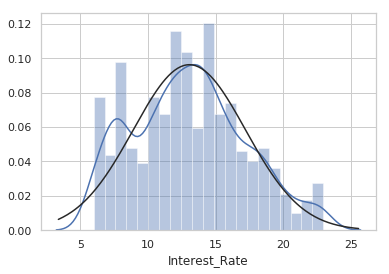

In [35]:
# checking normality of target
sns.set(style='whitegrid')
sns.distplot(data_new["Interest_Rate"],fit=stats.norm)
print(stats.skew(data_new["Interest_Rate"]))

In [36]:
# applying log transform on target variable
data_new['ln_Interest_Rate']=np.log(data_new['Interest_Rate'])

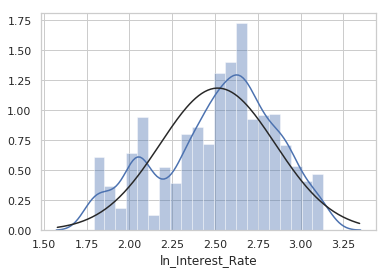

In [37]:
sns.distplot(data_new.ln_Interest_Rate,fit=stats.norm)

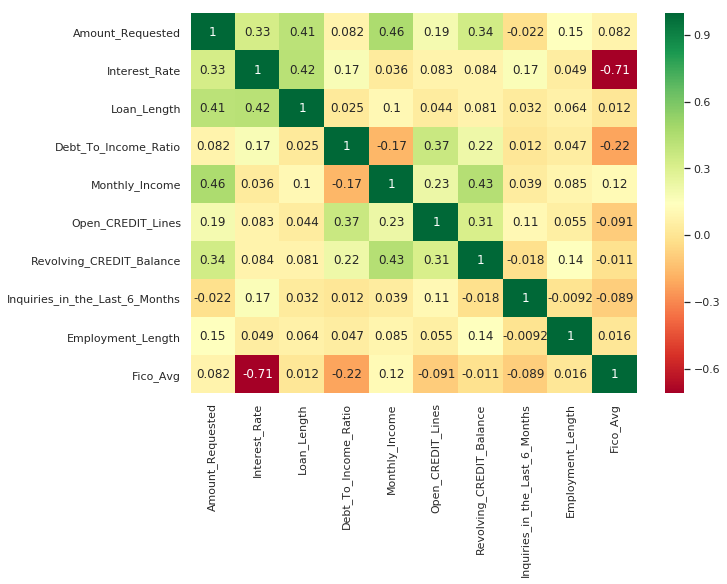

In [38]:
# chekcing collinearity
plt.figure(figsize=(10,7))
sns.heatmap(loan_num.corr(),annot=True,cmap='RdYlGn')

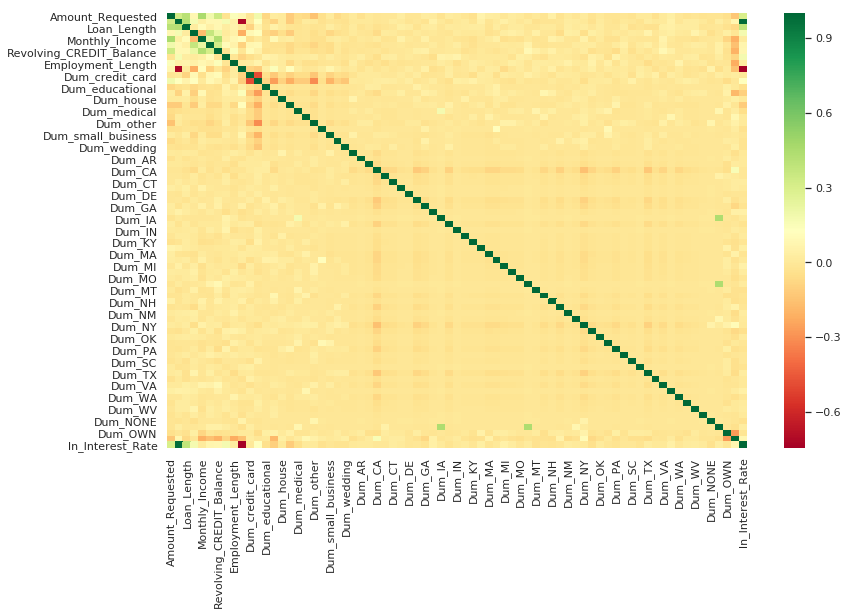

In [39]:
# checking multicollinearity
plt.figure(figsize=(13,8))
cormat=data_new.corr()
sns.heatmap(cormat,cmap='RdYlGn')

* Since most of the heatmap is yellow/near yellow color, it indicates that Multi-collinearity is less.

## Feature Engineering

In [40]:
feature_cols=data_new.columns.difference(['Interest_Rate','ln_Interest_Rate'])

In [41]:
feature_cols

Index(['Amount_Requested', 'Debt_To_Income_Ratio', 'Dum_AL', 'Dum_AR',
       'Dum_AZ', 'Dum_CA', 'Dum_CO', 'Dum_CT', 'Dum_DC', 'Dum_DE', 'Dum_FL',
       'Dum_GA', 'Dum_HI', 'Dum_IA', 'Dum_IL', 'Dum_IN', 'Dum_KS', 'Dum_KY',
       'Dum_LA', 'Dum_MA', 'Dum_MD', 'Dum_MI', 'Dum_MN', 'Dum_MO', 'Dum_MS',
       'Dum_MT', 'Dum_NC', 'Dum_NH', 'Dum_NJ', 'Dum_NM', 'Dum_NONE', 'Dum_NV',
       'Dum_NY', 'Dum_OH', 'Dum_OK', 'Dum_OR', 'Dum_OTHER', 'Dum_OWN',
       'Dum_PA', 'Dum_RENT', 'Dum_RI', 'Dum_SC', 'Dum_SD', 'Dum_TX', 'Dum_UT',
       'Dum_VA', 'Dum_VT', 'Dum_WA', 'Dum_WI', 'Dum_WV', 'Dum_WY',
       'Dum_credit_card', 'Dum_debt_consolidation', 'Dum_educational',
       'Dum_home_improvement', 'Dum_house', 'Dum_major_purchase',
       'Dum_medical', 'Dum_moving', 'Dum_other', 'Dum_renewable_energy',
       'Dum_small_business', 'Dum_vacation', 'Dum_wedding',
       'Employment_Length', 'Fico_Avg', 'Inquiries_in_the_Last_6_Months',
       'Loan_Length', 'Monthly_Income', 'Open_CREDIT_Lines

In [42]:
X=data_new[feature_cols]
y=data_new['ln_Interest_Rate']

In [43]:
# feature reduction using f_regression
F,p=f_regression(X,y)

In [44]:
f_reg_result=pd.DataFrame({'Feature':X.columns,'F-Score':F,'p-value':p.round(2)})

In [45]:
f_reg_result[f_reg_result['p-value']<0.05]

,Feature,F-Score,p-value
0,Amount_Requested,250.655568,0.00
1,Debt_To_Income_Ratio,82.470669,0.00
12,Dum_HI,4.923247,0.03
21,Dum_MI,6.405998,0.01
39,Dum_RENT,18.614306,0.00
46,Dum_VT,4.364751,0.04
52,Dum_debt_consolidation,45.367333,0.00
54,Dum_home_improvement,24.090299,0.00
56,Dum_major_purchase,31.625414,0.00
57,Dum_medical,5.121854,0.02


In [46]:
# taking all those features where p-values are significant and making into a list for further use
freg_list=f_reg_result[f_reg_result['p-value']<0.05]['Feature'].to_list()

In [47]:
a=X.columns.to_list()

In [48]:
# Variance Inflation Factor
vif=pd.DataFrame()
y,X=dmatrices(formula_like=('ln_Interest_Rate~'+'+'.join(a)),data=data_new,return_type='dataframe')
vif['Features']=X.columns
vif['VI_Factor']=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]

In [49]:
# filtering those features which have VIF less than equal to 4
vif[vif['VI_Factor']<=4]

,Features,VI_Factor
1,Amount_Requested,1.818637
2,Debt_To_Income_Ratio,1.470721
4,Dum_AR,2.182424
9,Dum_DC,2.002709
10,Dum_DE,1.728900
13,Dum_HI,2.095982
14,Dum_IA,1.472315
16,Dum_IN,1.280990
17,Dum_KS,2.897962
18,Dum_KY,3.086953


In [50]:
vif_list=vif[vif['VI_Factor']<=4]['Features'].to_list()

In [51]:
# selecting common features resultant from the various feature reduction methods, these features shall be used for model building
set(vif_list).intersection(freg_list)

{'Amount_Requested',
 'Debt_To_Income_Ratio',
 'Dum_HI',
 'Dum_RENT',
 'Dum_VT',
 'Dum_home_improvement',
 'Dum_major_purchase',
 'Dum_medical',
 'Fico_Avg',
 'Inquiries_in_the_Last_6_Months',
 'Loan_Length',
 'Open_CREDIT_Lines',
 'Revolving_CREDIT_Balance'}

## Model Building

In [52]:
X_new=['Amount_Requested',
 'Debt_To_Income_Ratio',
 'Dum_HI',
 'Dum_RENT',
 'Dum_VT',
 'Dum_home_improvement',
 'Dum_major_purchase',
 'Dum_medical',
 'Fico_Avg',
 'Inquiries_in_the_Last_6_Months',
 'Loan_Length',
 'Open_CREDIT_Lines',
 'Revolving_CREDIT_Balance']

In [53]:
# final data containing selected features and transformed target
data_final=pd.concat([data_new[X_new],y],axis=1)

In [54]:
# train-test splitting
train,test=train_test_split(data_final,test_size=0.3, random_state=3994)

In [55]:
fm=('ln_Interest_Rate~'+'+'.join(train.columns.difference(['ln_Interest_Rate','Dum_VT','Dum_major_purchase','Dum_HI',
                                                           'Dum_RENT','Dum_medical','Revolving_CREDIT_Balance','Debt_To_Income_Ratio'])))
model=smf.ols(fm,data=train).fit()

In [56]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       ln_Interest_Rate   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     1017.
Date:                Tue, 29 Oct 2019   Prob (F-statistic):               0.00
Time:                        18:44:06   Log-Likelihood:                 727.95
No. Observations:                1750   AIC:                            -1442.
Df Residuals:                    1743   BIC:                            -1404.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

* All features have significant p-values.
* R2 and adjR2- both are high and close to each other.

In [57]:
# VIF Check
y2,X2=dmatrices(fm,data=train,return_type='dataframe')
vif2=pd.DataFrame()
vif2['Features']=X2.columns
vif2['VI_Factor']=[variance_inflation_factor(X2.values,j) for j in range(X2.shape[1])]
vif2.sort_values(by='VI_Factor',ascending=False)

,Features,VI_Factor
0,Intercept,453.113246
1,Amount_Requested,1.298702
5,Loan_Length,1.251839
6,Open_CREDIT_Lines,1.056014
3,Fico_Avg,1.047440
4,Inquiries_in_the_Last_6_Months,1.031065
2,Dum_home_improvement,1.027989


* No Multi-collinearity among features in the model we made.

In [58]:
# reverse transformation of our target using exponential
train_y=np.exp(train['ln_Interest_Rate'])
test_y=np.exp(test['ln_Interest_Rate'])

In [59]:
# predicting for train and test data
train_pred=np.exp(model.predict(train))
test_pred=np.exp(model.predict(test))

In [60]:
# evaluation metrics calculation

r2_train=metrics.r2_score(y_true=train_y,y_pred=train_pred)
r2_test=metrics.r2_score(y_true=test_y,y_pred=test_pred)
mae_train=metrics.mean_absolute_error(y_true=train_y,y_pred=train_pred)
mae_test=metrics.mean_absolute_error(y_true=test_y,y_pred=test_pred)
mse_test=metrics.mean_squared_error(y_true=test_y,y_pred=test_pred)
mse_train=metrics.mean_squared_error(y_true=train_y,y_pred=train_pred)
train_cor=np.corrcoef(train_y,train_pred)[0][1]
test_cor=np.corrcoef(test_y,test_pred)[0][1]

In [61]:
model_eva=pd.DataFrame(index=['MAE','MSE','R2_Score','Corr.Coeff.'],columns=['Train',"Test"],data={'Train':[mae_train,mse_train,r2_train,train_cor],
                                                                                     'Test':[mae_test,mse_test,r2_test,test_cor]})

In [62]:
model_eva

,Train,Test
MAE,1.462760,1.473775
MSE,3.790132,3.887454
R2_Score,0.780478,0.771540
Corr.Coeff.,0.884218,0.879476


* The metrics for both train and test are similar, also correlation of predicted values with actual values is high.

In [63]:
# Decile Analysis for train data
train_new=pd.concat([train_y,train_pred],axis=1)
train_new.columns=['Actual','Predicted']
train_new['Deciles']=pd.qcut(train_new.Predicted,10,labels=False)
df1=train_new.groupby('Deciles').mean()
df1

,Actual,Predicted
Deciles,,
0,7.299657,6.949984
1,8.561977,8.911147
2,9.814629,10.251335
3,11.286400,11.351755
4,12.810629,12.393421
5,13.540343,13.245215
6,14.892686,14.137388
7,15.705029,15.043598
8,16.581829,16.329988


[Text(0, 0.5, '')]

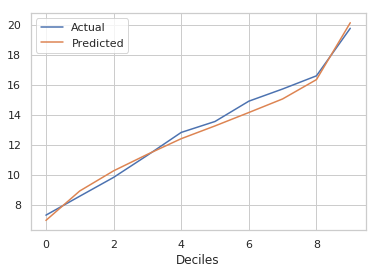

In [64]:
sns.lineplot(x=df1.index,y='Actual',data=df1,label='Actual')
ax=sns.lineplot(x=df1.index,y='Predicted',data=df1,label='Predicted')
ax.set(ylabel='')

* From above dataframe and plot :
    * We see that for our training data both Actual and the predicted values increase with increasing deciles, i.e rank order is mainteined.

In [65]:
test_new=pd.concat([test_y,test_pred],axis=1)
test_new.columns=['Actual','Predicted']
test_new['Deciles']=pd.qcut(test_new.Predicted,10,labels=False)
df2=test_new.groupby('Deciles').mean()
df2

,Actual,Predicted
Deciles,,
0,7.519547,7.072150
1,8.913440,9.290742
2,10.077333,10.370272
3,11.262800,11.364735
4,12.893600,12.373910
5,13.455467,13.270763
6,14.608667,14.029818
7,15.637200,15.017392
8,17.400933,16.545269


[Text(0, 0.5, '')]

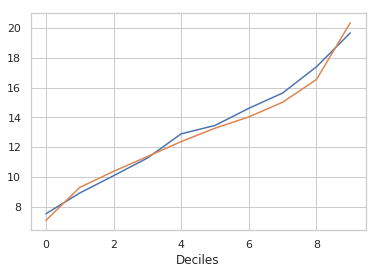

In [66]:
sns.lineplot(x=df2.index,y='Actual',data=df2)
ax=sns.lineplot(x=df2.index,y='Predicted',data=df2)
ax.set(ylabel='')

* From above dataframe and plot :
    * We see that for our testing data both Actual and the predicted values increase with increasing deciles, i.e rank order is mainteined here also.

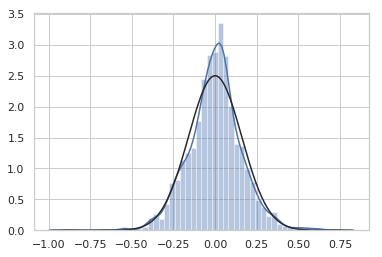

In [67]:
# distribution of residuals
sns.distplot(model.resid,fit=stats.norm)

-C.Varun

~ END ~